# Statistics

Chapter 11 of Python for Finance (continued)

Hilpisch, Yves. Python for Finance: Analyze Big Financial Data. O'Reilly Media. Kindle Edition.

* Principal Components Analysis
* Bayesian Regression

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import data as web
from sklearn.decomposition import KernelPCA

%matplotlib inline

### The DAX index and it's 30 Stocks

In [2]:
symbols = ['ADS.DE', 'ALV.DE', 'BAS.DE', 'BAYN.DE', 
           'BEI.DE', 'BMW.DE', 'CBK.DE', 'CON.DE', 
           'DAI.DE', 'DB1.DE', 'DBK.DE', 'DPW.DE', 
           'DTE.DE', 'EOAN.DE', 'FME.DE', 'FRE.DE', 
           'HEI.DE', 'HEN3.DE', 'IFX.DE', 'LHA.DE',
           'LIN.DE', 'LXS.DE', 'MRK.DE', 'MUV2.DE', 
           'RWE.DE', 'SAP.DE', 'SDF.DE', 'SIE.DE', 
           'TKA.DE', 'VOW3.DE', '^GDAXI']

In [3]:
%%time
data = pd.DataFrame()
for sym in symbols:
    data[sym] = web.DataReader(sym, data_source='yahoo')['Close']

data = data.dropna()

Wall time: 5.43 s


In [4]:
dax = pd.DataFrame(data.pop('^GDAXI'))

In [5]:
data[data.columns[:6]].head()

,ADS.DE,ALV.DE,BAS.DE,BAYN.DE,BEI.DE,BMW.DE
Date,,,,,,
2010-01-04,38.505,88.54,44.850,56.40,46.445,32.050
2010-01-05,39.720,88.81,44.170,55.37,46.200,32.310
2010-01-06,39.400,89.50,44.450,55.02,46.165,32.810
2010-01-07,39.745,88.47,44.155,54.30,45.700,33.100
2010-01-08,39.600,87.99,44.020,53.82,44.380,32.655


In [6]:
# normalizing the data
scale_function = lambda x: (x - x.mean()) / x.std()

In [7]:
pca = KernelPCA().fit(data.apply(scale_function))

In [8]:
len(pca.lambdas_)

886

In [9]:
pca.lambdas_[:10].round()

array([ 33116.,   5979.,   5406.,   2549.,   2003.,    870.,    732.,
          528.,    304.,    215.])

In [10]:
get_we = lambda x: x / x.sum()

In [11]:
get_we(pca.lambdas_)[:10]

array([ 0.62898522,  0.11356271,  0.10268472,  0.0484177 ,  0.03804536,
        0.01652891,  0.01389949,  0.01003597,  0.00578017,  0.00407997])

In [12]:
get_we(pca.lambdas_)[:5].sum()

0.93169570381523037

### Constructing a PCA index

In [13]:
pca = KernelPCA(n_components=1).fit(data.apply(scale_function))

In [14]:
dax['PCA_1'] = pca.transform(-data)

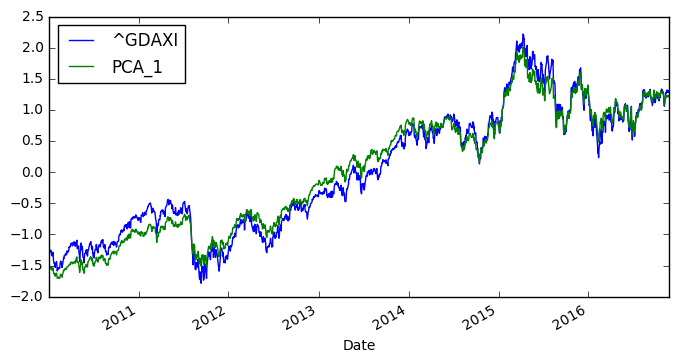

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

dax.apply(scale_function).plot(figsize=(8,4))

In [16]:
# adding components
pca = KernelPCA(n_components=5).fit(data.apply(scale_function))
pca_components = pca.transform(data)
weights = get_we(pca.lambdas_)
dax['PCA_5'] = np.dot(pca_components, weights)

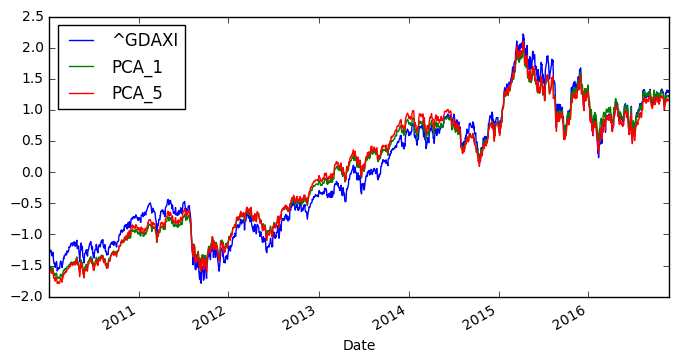

In [17]:
dax.apply(scale_function).plot(figsize=(8,4))

In [28]:
import matplotlib as mpl 
mpl_dates = mpl.dates.date2num(data.index.tolist())

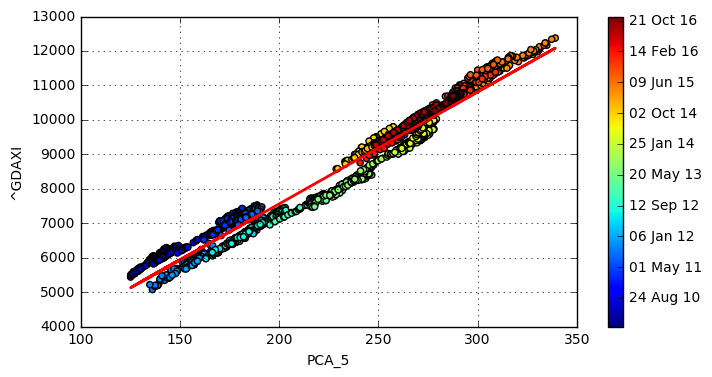

In [30]:
plt.figure(figsize=(8,4))
plt.scatter(dax['PCA_5'], dax['^GDAXI'], c=mpl_dates)
lin_reg = np.polyval(np.polyfit(dax['PCA_5'], 
                               dax['^GDAXI'], 1),
                     dax['PCA_5'])
plt.plot(dax['PCA_5'], lin_reg, 'r', lw=2)
plt.grid(True)
plt.xlabel('PCA_5')
plt.ylabel('^GDAXI')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250),
            format=mpl.dates.DateFormatter('%d %b %y'))

Cutting the time frame into separate intervals to try for a better fit:

In [34]:
cut_date = '2011/7/1'
early_pca = dax[dax.index < cut_date]['PCA_5']
early_reg = np.polyval(np.polyfit(early_pca, 
                                  dax[dax.index < cut_date]['^GDAXI'], 1),
                       early_pca)

In [36]:
late_pca = dax[dax.index >= cut_date]['PCA_5']
late_reg = np.polyval(np.polyfit(late_pca, 
                                  dax[dax.index >= cut_date]['^GDAXI'], 1),
                       late_pca)

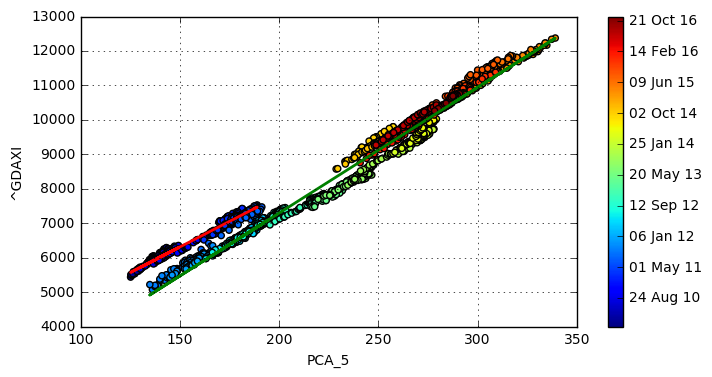

In [39]:
plt.figure(figsize=(8,4))
plt.scatter(dax['PCA_5'], dax['^GDAXI'], c=mpl_dates)
lin_reg = np.polyval(np.polyfit(dax['PCA_5'], 
                               dax['^GDAXI'], 1),
                     dax['PCA_5'])
plt.plot(early_pca, early_reg, 'r', lw=2)
plt.plot(late_pca, late_reg, 'g', lw=2)
plt.grid(True)
plt.xlabel('PCA_5')
plt.ylabel('^GDAXI')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250),
            format=mpl.dates.DateFormatter('%d %b %y'))